# 4 Degree of Freedom Robot Arm

In [11]:
import time
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from IPython.display import display, Math

from tools import *

## Variables and settings

In [12]:
# Constants
l0 = symbols('l_0')
l2 = symbols('l_2')
l3 = symbols('l_3')
l4 = symbols('l_4')
le = symbols('l_e')
l0_val = 15
l2_val = 20
l3_val = 15
l4_val = 5
le_val = 10

# Variables
theta2 = symbols(r"\theta_2")
theta3 = symbols(r"\theta_3")
theta4 = symbols(r"\theta_4")
d1 = symbols('d_1')

alias = {}

# display cos(theta) as c\theta, sin(theta) as s\theta
alias.update({sin(theta2): symbols(r"s\theta_2"),
              cos(theta2): symbols(r"c\theta_2"),
              sin(theta3): symbols(r"s\theta_3"),
              cos(theta3): symbols(r"c\theta_3"),
              sin(theta4): symbols(r"s\theta_4"),
              cos(theta4): symbols(r"c\theta_4")})

## Transformation Metrics (see forward_kinematics.py)

In [13]:
R01, T01 = get_trans_mat(0, 0, l0+d1, 0)
R12, T12 = get_trans_mat(0, 0, 0, theta2)
R23, T23 = get_trans_mat(l2, 90, 0, theta3+pi/2)
R34, T34 = get_trans_mat(0, 90, l3, theta4)
R4e, T4e = get_trans_mat(-le, 0, l4, 0)

T04 = T01 * T12 * T23 * T34
T0e = T04 * T4e

## Inverse Kinematics to find $\theta$ values from the position metrices

In [14]:
def get_random_trans_mat():
    """
    Obtain random position metrices by applying forward kinematics using
    randomly assigned theta2, theta3, theta4 & d1 values.
    Random assignment is for proving concepts and is practically useless.
    """
    theta2_val = (np.random.rand()*360-180)/180*np.pi
    theta3_val = (np.random.rand()*180-90)/180*np.pi
    theta4_val = (np.random.rand()*360-180)/180*np.pi
    d1_val = 5 + np.random.rand() * 35

    values = {l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val, 
              theta2: theta2_val, theta3: theta3_val, theta4: theta4_val, 
              d1: d1_val}
    T0e_target = T0e.subs(values)
    # convert infinitely small non-zero float to zero
    T0e_target = np.array(T0e_target, dtype=np.float32)
    T0e_target[np.abs(T0e_target) < 1e-7] = 0
    
    return T0e_target

In [15]:
def solve_inverse_kinematics(vals_target, show_ans=False):
    # ========================= d1 ==============================
    d1_inv =le*r31 - l4*r33 + Z - l0 - l3*r33
    d1_ans = float(d1_inv.subs(vals_target))
    if show_ans:
        eqnprint(d1, alias, None, d1_ans)

    # ========================= theta2 ==========================
    theta2_inv = atan2((le*r21 - r23*(l3+l4) + Y)/l2, (le*r11 - r13*(l3+l4) + X)/l2)
    theta2_ans = float(theta2_inv.subs(vals_target))
    if show_ans:
        eqnprint(theta2, alias, None, theta2_ans)

    # ========================= theta3 ==========================
    if sin(theta2_ans) != 0:
        theta3_inv = atan2(r33, r23/sin(theta2_ans))
    else:
        theta3_inv = atan2(r33, r13/cos(theta2_ans))

    theta3_ans = float(theta3_inv.subs(vals_target))
    # theta3 range from -180 to 180 deg
    if theta3_ans > np.pi:
        theta3_ans -= 2*np.pi 
    if show_ans:
        eqnprint(theta3, alias, None, theta3_ans)

    # ========================= theta4 ==========================
    if theta3_ans == np.pi/2:
        theta4_inv = atan2(r12, -r11) - theta2_ans
    elif theta3_ans == -np.pi/2:
        theta4_inv = atan2(-r12, r11) + theta2_ans
    else:
        theta4_inv = atan2(-r32/cos(theta3_ans), r31/cos(theta3_ans))

    theta4_ans = float(theta4_inv.subs(vals_target))
    # theta4 range from -180 to 180 deg
    if theta4_ans > np.pi:
        theta4_ans -= 2*np.pi 
    if show_ans:
        eqnprint(theta4, alias, None, theta4_ans)
    
    return d1_ans, theta2_ans, theta3_ans, theta4_ans


In [16]:
r11 = symbols('r_{11}')
r12 = symbols('r_{12}')
r13 = symbols('r_{13}')
r21 = symbols('r_{21}')
r22 = symbols('r_{22}')
r23 = symbols('r_{23}')
r31 = symbols('r_{31}')
r32 = symbols('r_{32}')
r33 = symbols('r_{33}')
X = symbols('X')
Y = symbols('Y')
Z = symbols('Z')
empty_vals = {r11: None, r12: None, r13: None, 
              r21: None, r22: None, r23: None, 
              r31: None, r32: None, r33: None, 
              X: None, Y: None, Z: None}

In [17]:
num_via_points = 10

# + 2 because start and end points:
d1_points = np.ndarray(num_via_points + 2)
theta2_points = np.ndarray(num_via_points + 2)
theta3_points = np.ndarray(num_via_points + 2)
theta4_points = np.ndarray(num_via_points + 2)

# XYZ values for target positions:
P_coordinates = np.ndarray([num_via_points + 2, 3])

for i in range(num_via_points + 2):
    P = get_random_trans_mat()
#     print(P[:3, -1])
    P_coordinates[i, :] = P[:3, -1]
    # get rii, X, Y, Z
    vals_target = update_target_vals(P, empty_vals)
    vals_target.update({l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val})
    if i == 0:
        print('======> Start Position:')
        symprint('P', 0, 'start')
        matprint(Matrix(P))
        show_ans = True
    elif i == num_via_points + 1:
        print('======> End Position:')
        symprint('P', 0, 'start')
        matprint(Matrix(P))
        show_ans = True
    else:
        show_ans = False
        
    # solve theta values
    d1_points[i], theta2_points[i], theta3_points[i], theta4_points[i] = solve_inverse_kinematics(vals_target, show_ans=show_ans)

======> Start Position:


^0P_start

Matrix([
[-0.518397, -0.230297,  -0.823546, -31.1417],
[-0.267228,   0.95845, -0.0998101, -1.73023],
[ 0.812314,  0.168333,    -0.5584,  8.75109],
[        0,         0,          0,      1.0]])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

======> End Position:


^0P_start

Matrix([
[ 0.810192, -0.554712,   0.18943, 9.57942],
[-0.584778, -0.787116,  0.196172, 24.1584],
[0.0402844, -0.269711, -0.962098, 4.15528],
[        0,         0,         0,     1.0]])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now we have arrays for each theta, each array has a length of 12, corresponding to 12 points.

The next step is to solve $a$, $V$, $t_{blend}$ and $t_{linear}$.

In [18]:
def calc_kinematics_parameters(via_points, tf):
    a_mins = np.ndarray(num_via_points + 2)  # minimum required accelerations
    a_vals = np.ndarray(num_via_points + 2)  # actual acclerations
    V_vals = np.ndarray(num_via_points + 1)  # velocity for linear regions
    t_blends = np.ndarray(num_via_points + 2)  # time for blend regions
    t_linears = np.ndarray(num_via_points + 1)  # time for linear regions

#     a_mins[:-1] = 2 * (via_points[1:] - via_points[:-1]) / (tf/2)**2
#     a_mins[-1] = a_mins[-2]  # make the last acceleration magnitude = second last 

    a_mins[0] = np.abs(8*(via_points[1]-via_points[0]) / (3*tf[0]**2))
    a_mins[-1] = np.abs(8*(via_points[-1]-via_points[-2]) / (3*tf[-1]**2))
    # for the middle segments:
    left = ((via_points[2:]-via_points[1:-1])/tf[1:] - (via_points[1:-1]-via_points[:-2])/tf[:-1]) / tf[:-1]
    right = ((via_points[2:]-via_points[1:-1])/tf[1:] - (via_points[1:-1]-via_points[:-2])/tf[:-1]) / tf[1:]
    a_mins[1:-1] = np.maximum(np.abs(left), np.abs(right))
    a_mins = 2 * a_mins

    # Step 1: Find the start and end acceleration:
    a_vals[0] = np.sign(via_points[1] - via_points[0]) * a_mins[0]
    a_vals[-1] = np.sign(via_points[-2] - via_points[-1]) * a_mins[-1]

    # Step 2: Find the start and end blend times (using a_vals[0] and a_vals[-1]):
    t_blends[0] = tf[0] - np.sqrt(tf[0]**2 - 2*(via_points[1]-via_points[0])/a_vals[0])
    t_blends[-1] = tf[-1] - np.sqrt(tf[-1]**2 + 2*(via_points[-1]-via_points[-2])/a_vals[-1])

    # Step3: Find the start and end velocity (using t_blends[0] and t_blends[-1]):
    V_vals[0] = (via_points[1]-via_points[0]) / (tf[0]-0.5*t_blends[0])
    V_vals[-1] = (via_points[-1]-via_points[-2]) / (tf[-1]-0.5*t_blends[-1])

    # Step 4: Find middle via points velocity at linear regions:
    V_vals[1:-1] = (via_points[2:-1] - via_points[1:-2]) / tf[1:-1]

    # Step 5: Find middle via points blend acceleration (using V_vals[:]):
    a_vals[1:-1] = np.sign(V_vals[1:] - V_vals[:-1]) * a_mins[1:-1]

    # Step 6: Find middle via points blend times (using V_vals[:] and a_vals[1:-1]):
    t_blends[1:-1] = (V_vals[1:] - V_vals[:-1]) / a_vals[1:-1]

    # Step 6: Find all times for linear regions (using t_blends[:]):
    t_linears[0] = tf[0] - t_blends[0] - 0.5*t_blends[1]
    t_linears[-1] = tf[-1] - t_blends[-1] - 0.5*t_blends[-2]
    t_linears[1:-1] = tf[1:-1] - 0.5*t_blends[2:-1] - 0.5*t_blends[1:-2]

    print('points position:', via_points)
    print('acceleration:', a_vals)
    print('linear velocity:', V_vals)
    print('blend time:', t_blends)
    print('time for linear region:', t_linears)
    
    return a_vals, V_vals, t_blends, t_linears

In [19]:
# calculate distance between two points position
dist = np.sqrt(np.sum((P_coordinates[1:] - P_coordinates[:-1])**2, axis=1))
t_tot = 25  # total time: 25 s
# time between two points depending on the distance
tf = dist/np.sum(dist) * t_tot
print('tf:', tf)

display(d1)
a_vals_d1, V_vals_d1, b_blends_d1, t_linears_d1 = calc_kinematics_parameters(d1_points, tf)

display(theta2)
a_vals_theta2, V_vals_theta2, b_blends_theta2, t_linears_theta2 = calc_kinematics_parameters(theta2_points, tf)

display(theta3)
a_vals_theta3, V_vals_theta3, b_blends_theta3, t_linears_theta3 = calc_kinematics_parameters(theta3_points, tf)

display(theta4)
a_vals_theta4, V_vals_theta4, b_blends_theta4, t_linears_theta4 = calc_kinematics_parameters(theta4_points, tf)

tf: [1.32034602 2.1062938  3.0322302  0.95071542 2.35223045 2.0872948
 3.05838139 2.93879105 1.55105259 3.36543732 2.23722695]


d_1

points position: [13.04222679 31.46809387 24.18757248 38.16073608 26.71199989 36.72400284
  7.46196556 39.8733139   5.81076908 22.47488213 16.60070229  8.80009079]
acceleration: [ 56.37040304 -26.37473391   7.65778145 -35.02719225  34.28706249
 -17.51118956  23.58715221 -15.10023334  28.79903688 -16.10414497
  -1.55664947   8.31203365]
linear velocity: [ 15.58759117  -3.45655548   4.60821332 -12.04223257   4.25638693
 -14.0191205   10.59754955 -11.59066576  10.74374467  -1.74544325
  -3.8945514 ]
blend time: [0.27652084 0.72206024 1.0531469  0.47535771 0.47535771 1.0436474
 1.0436474  1.46939553 0.7755263  0.7755263  1.38059865 0.46854375]
time for linear region: [0.68279506 1.21869023 2.2679779  0.47535771 1.5927279  1.0436474
 1.80185993 1.81633014 0.7755263  2.28737484 1.07838387]


\theta_2

points position: [-3.02098528 -2.86186001  2.01702872  3.10591442 -2.89229474  1.43823361
  2.93911094 -1.07775617  3.04668951  2.32933203  0.68978035  0.80288041]
acceleration: [  0.48681321   3.32612858  -1.85846273 -14.02787181  17.14536989
  -1.07505353  -1.94744914   1.84895499  -2.40603961  -0.0318187
   0.4807086   -0.1205151 ]
linear velocity: [ 0.134614    2.31633817  0.3591039  -6.30915312  1.84103065  0.71905383
 -1.3133964   1.40344979 -0.4624972  -0.48717344  0.05646659]
blend time: [0.27652084 0.65593501 1.0531469  0.47535771 0.47535771 1.0436474
 1.0436474  1.46939553 0.7755263  0.7755263  1.13091389 0.46854375]
time for linear region: [0.71585768 1.25175285 2.2679779  0.47535771 1.5927279  1.0436474
 1.80185993 1.81633014 0.7755263  2.41221722 1.20322625]


\theta_3

points position: [-0.59245558 -1.2049384  -1.35459699  1.34547709  1.46376696 -1.12075325
 -1.49191119 -1.21110821  0.4633358   0.17680186  0.02146763 -1.29459499]
acceleration: [-1.87377361  0.59503719  0.91298867 -1.61149417 -2.57316735  0.88241995
  0.25835539  0.32527582 -0.97289832  0.17869081 -0.48461821  1.40234606]
linear velocity: [-0.51813745 -0.07105305  0.89045814  0.12442196 -1.09875298 -0.17781769
  0.09181424  0.56977308 -0.18473515 -0.04615573 -0.65706048]
blend time: [0.27652084 0.7513554  1.0531469  0.47535771 0.47535771 1.0436474
 1.0436474  1.46939553 0.7755263  0.7755263  1.26058973 0.46854375]
time for linear region: [0.66814748 1.20404265 2.2679779  0.47535771 1.5927279  1.0436474
 1.80185993 1.81633014 0.7755263  2.3473793  1.13838833]


\theta_4

points position: [-0.20433454  2.32068321 -0.16323594 -3.1039574  -1.1899915   2.04886835
 -1.42366849 -1.76352225  0.4402506   0.53805696 -2.69911749  1.4225312 ]
acceleration: [ 7.72480707 -4.68312874  0.19889245  6.27528725 -1.33847313 -2.91342228
  1.48760217  0.58596412 -0.88563458 -1.32161381  2.50684505 -4.39187141]
linear velocity: [ 2.13607014 -1.17928427 -0.9698213   2.01318487  1.37693135 -1.66365424
 -0.1111221   0.74989096  0.06305806 -0.9618882   2.05778389]
blend time: [0.27652084 0.70793578 1.0531469  0.47535771 0.47535771 1.0436474
 1.0436474  1.46939553 0.7755263  0.7755263  1.2045707  0.46854375]
time for linear region: [0.68985729 1.22575246 2.2679779  0.47535771 1.5927279  1.0436474
 1.80185993 1.81633014 0.7755263  2.37538882 1.16639785]


In [26]:
def plot_trajectory(via_points, tf, a_vals, V_vals, t_blends, t_linears, 
                    ylabel, resolution=1000, plot=True):
    # for the whole trajectory
    time_history = []
    disp_history = []
    velo_history = []
    acc_history = []
    disp_ideal_history = []
    t_start = 0

    # initialise starting values
    disp_last = via_points[0]
    velo_last = 0
    
    if plot:
        fig, axes = plt.subplots(1, 3)
    # Need plots for each segment:
    for i in range(num_via_points + 1):
        t_local = np.linspace(0, tf[i], resolution)
        tb_left = t_blends[i] if i == 0 else t_blends[i]/2
        tb_right = t_blends[i+1] if i == num_via_points else t_blends[i+1]/2
        disp, velo, acc, disp_ideal = calc_parabolic_traj_via_points(t_local, disp_last, velo_last, 
                                                         V_vals[i], a_vals[i],
                                                         a_vals[i+1], tb_left, tb_right)
        # use last points as the initial points for the next segment
        disp_last = disp[-1]
        velo_last = velo[-1]

        time_history.extend((t_local + t_start).tolist())

        disp_history.extend(disp.tolist())
        velo_history.extend(velo.tolist())
        acc_history.extend(acc.tolist())
        disp_ideal_history.extend(disp_ideal.tolist())
        
        if plot:
            axes[0].plot(t_start, via_points[i], 'rx')
#         plt.axvline(t_start, color='red', linestyle='--')
        t_start += tf[i]

    if plot:
        unit = 'cm' if ylabel == '$d_1$' else 'rad'
        
        axes[0].plot(t_start, via_points[-1], 'rx')
    #     plt.axvline(t_start, color='red', linestyle='--')
        axes[0].plot(time_history, disp_ideal_history, 'b--')
        axes[0].plot(time_history, disp_history)
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('{} Displacement (${}$)'.format(ylabel, unit))
#         axes[0].set_title(ylabel + ' Displacement')

        axes[1].plot(time_history, velo_history)
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('{} Velocity (${}/s$)'.format(ylabel, unit))
#         axes[1].set_title(ylabel + ' Velocity')

        axes[2].plot(time_history, acc_history)
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('{} Acceleration (${}/s^2$)'.format(ylabel, unit))
#         axes[2].set_title(ylabel + ' Acceleration')

        fig.set_figheight(5)
        fig.set_figwidth(18)
        plt.show()
    
    return time_history, disp_history

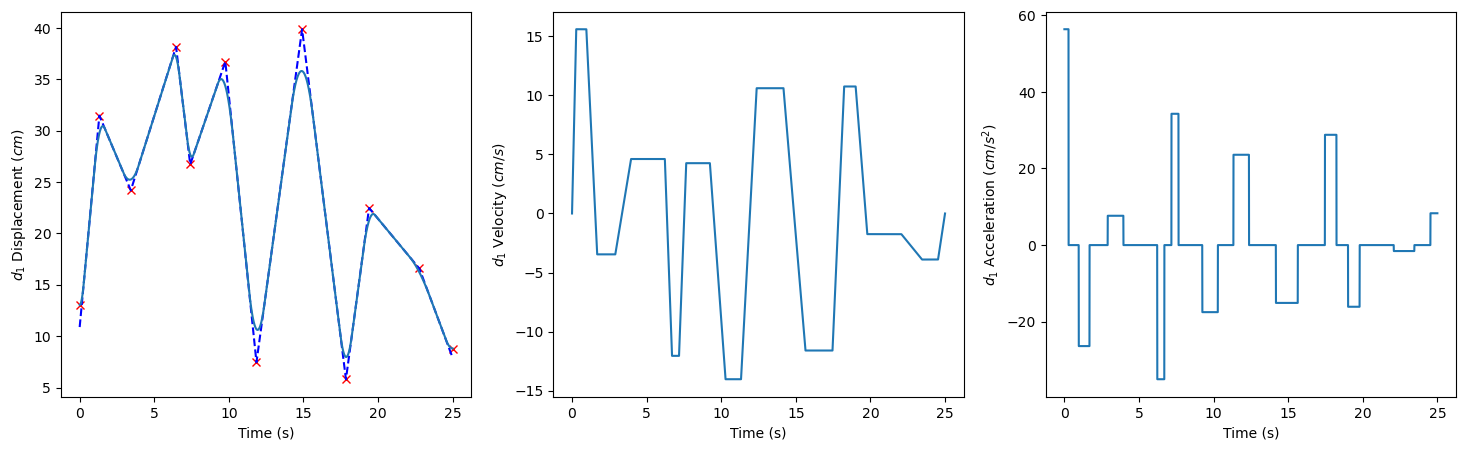

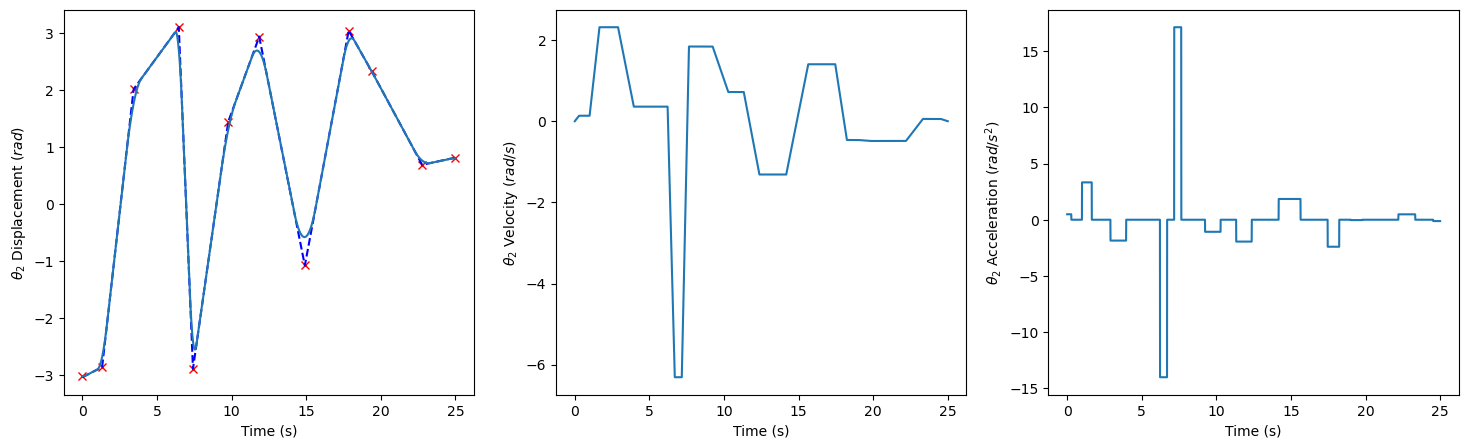

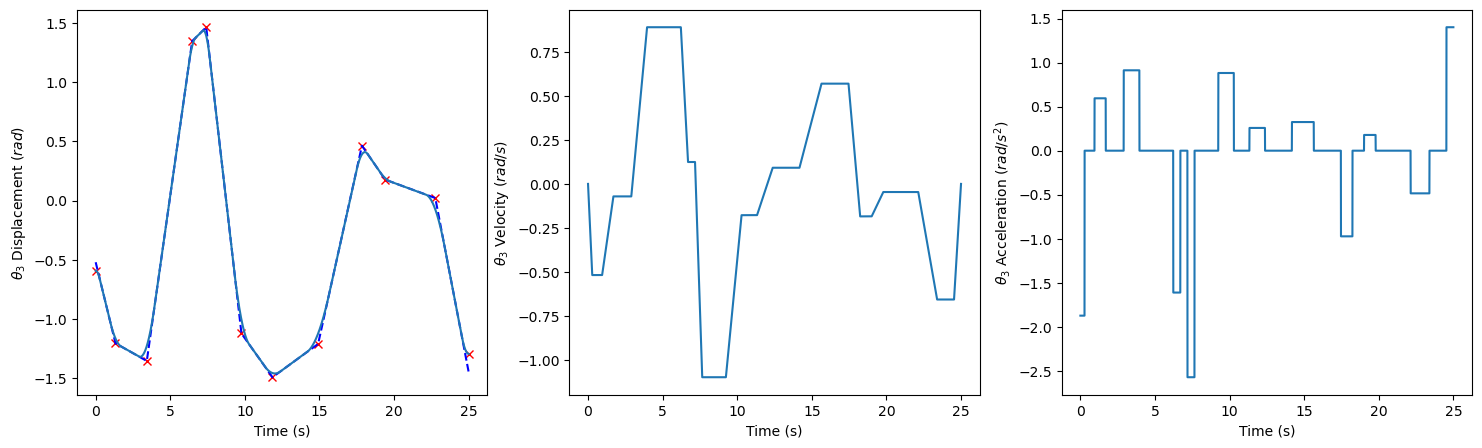

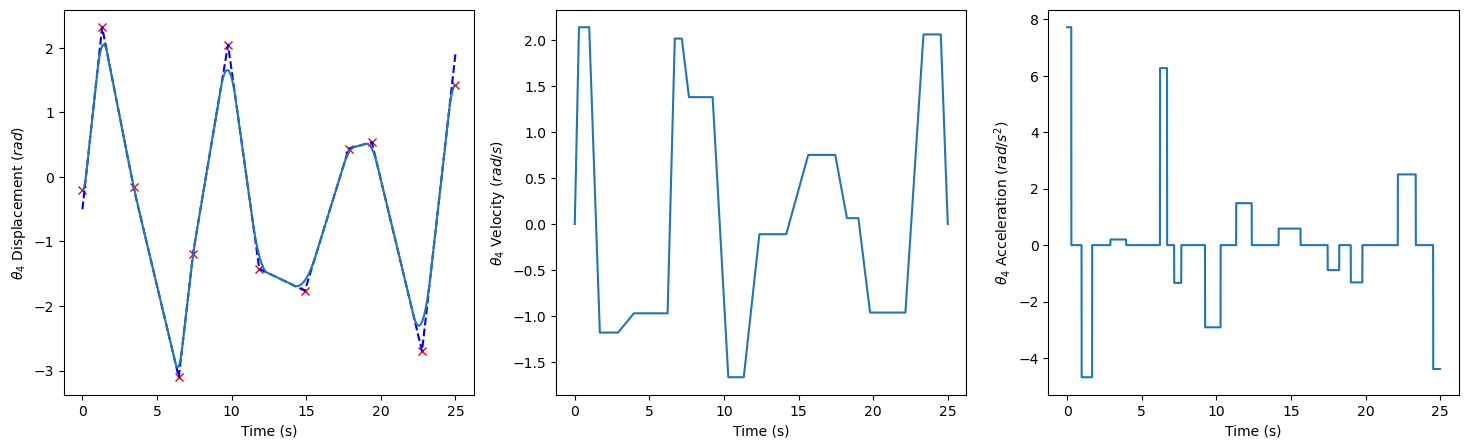

In [27]:
%matplotlib inline
_, _ = plot_trajectory(d1_points, tf, a_vals_d1, V_vals_d1, b_blends_d1, t_linears_d1, '$d_1$')
_, _ = plot_trajectory(theta2_points, tf, a_vals_theta2, V_vals_theta2, b_blends_theta2, t_linears_theta2, '$\\theta_2$')
_, _ = plot_trajectory(theta3_points, tf, a_vals_theta3, V_vals_theta3, b_blends_theta3, t_linears_theta3, '$\\theta_3$')
_, _ = plot_trajectory(theta4_points, tf, a_vals_theta4, V_vals_theta4, b_blends_theta4, t_linears_theta4, '$\\theta_4$')

## Cartesian Workspace Animation

In [31]:
res = 10
_, d1_paths = plot_trajectory(d1_points, tf, a_vals_d1, V_vals_d1, b_blends_d1, 
                              t_linears_d1, '$d_1$', resolution=res, plot=False)
_, theta2_paths = plot_trajectory(theta2_points, tf, a_vals_theta2, V_vals_theta2, b_blends_theta2, 
                                  t_linears_theta2, '$\\theta_2$', resolution=res, plot=False)
_, theta3_paths = plot_trajectory(theta3_points, tf, a_vals_theta3, V_vals_theta3, b_blends_theta3, 
                                  t_linears_theta3, '$\\theta_3$', resolution=res, plot=False)
_, theta4_paths = plot_trajectory(theta4_points, tf, a_vals_theta4, V_vals_theta4, b_blends_theta4, 
                                  t_linears_theta4, '$\\theta_4$', resolution=res, plot=False)

# Get the Position of end effector in frame 0
Pee = Matrix([0, 0, 0, 1])
P0e = T0e * Pee

<IPython.core.display.Javascript object>


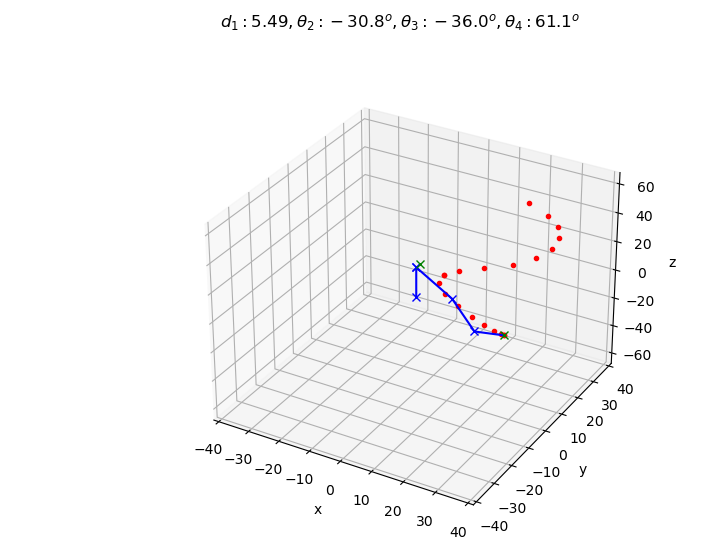

In [12]:
%matplotlib notebook

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
x_max = l2_val + l3_val + l4_val
z_max = 40 + l0_val + le_val
ax.set_xlim([-x_max*1, x_max*1])
ax.set_ylim([-x_max*1, x_max*1])
ax.set_zlim([-z_max*1, z_max*1])

line1, = ax.plot([0], [0], [0], 'r.')  # end effector
line2, = ax.plot([0], [0], [0], 'b-')  # link
line3, = ax.plot([0], [0], [0], 'bx')  # joint
line4, = ax.plot([P_coordinates[0, 0]], [P_coordinates[0, 1]], [P_coordinates[0, 2]], 'gx')  # via points

end_memory = []  # show end effector history

for i in range(len(d1_paths)):
    d1_val = d1_paths[i]
    theta2_val = theta2_paths[i]
    theta3_val = theta3_paths[i]
    theta4_val = theta4_paths[i]
    values = {l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val, 
              theta2: theta2_val, theta3: theta3_val, theta4: theta4_val, 
              d1: d1_val}
    end_pos = P0e.subs(values)

    if len(end_memory) < 20:
        end_memory.append(end_pos[:3])
    else:
        end_memory = end_memory[1:] + [end_pos[:3]]

    line1.set_xdata([i[0] for i in end_memory])
    line1.set_ydata([i[1] for i in end_memory])
    line1.set_3d_properties([i[2] for i in end_memory])

    Pii_pos = Matrix([0, 0, 0, 1])
    P01_pos = (T01 * Pii_pos).subs(values)
    P02_pos = (T01 * T12 * Pii_pos).subs(values)
    P03_pos = (T01 * T12 * T23 * Pii_pos).subs(values)
    P04_pos = (T01 * T12 * T23 * T34 * Pii_pos).subs(values)

    plot_links_moving(line2, line3, [Pii_pos, P01_pos, P02_pos, P03_pos, P04_pos, end_pos])
    
    # plot via points
    line4.set_xdata(P_coordinates[i//res:i//res+2, 0])
    line4.set_ydata(P_coordinates[i//res:i//res+2, 1])
    line4.set_3d_properties(P_coordinates[i//res:i//res+2, 2])
    
    fig.suptitle('$d_1: %.2f, \\theta_2: %.1f^o, \\theta_3: %.1f^o, \
                 \\theta_4: %.1f^o$' % (d1_val, theta2_val/pi*180, theta3_val/pi*180, theta4_val/pi*180))
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.1)


## Overall Trajectory in Cartesian Space (at end position)

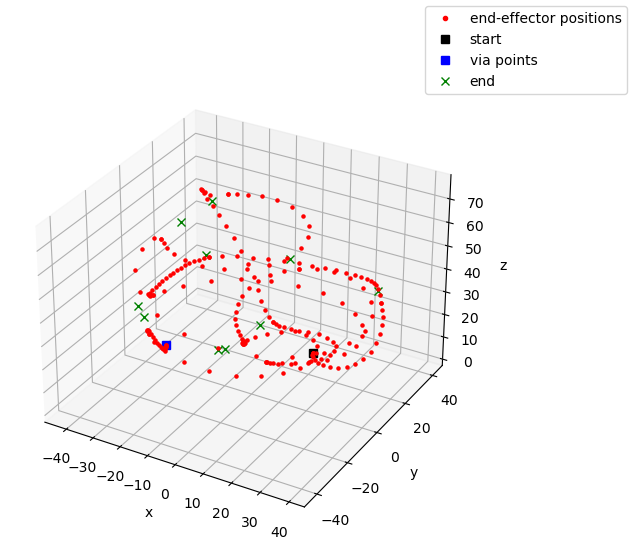

In [47]:
%matplotlib inline

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
x_max = l2_val + l3_val + l4_val
z_max = 40 + l0_val + le_val
# ax.set_xlim([-x_max*1, x_max*1])
# ax.set_ylim([-x_max*1, x_max*1])
# ax.set_zlim([-z_max*1, z_max*1])

for i in range(len(d1_paths)):
    d1_val = d1_paths[i]
    theta2_val = theta2_paths[i]
    theta3_val = theta3_paths[i]
    theta4_val = theta4_paths[i]
    values = {l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val, 
              theta2: theta2_val, theta3: theta3_val, theta4: theta4_val, 
              d1: d1_val}
    end_pos = P0e.subs(values)
    ax.scatter(end_pos[0], end_pos[1], end_pos[2], c='r', marker='.')
    
Pii_pos = Matrix([0, 0, 0, 1])
P01_pos = (T01 * Pii_pos).subs(values)
P02_pos = (T01 * T12 * Pii_pos).subs(values)
P03_pos = (T01 * T12 * T23 * Pii_pos).subs(values)
P04_pos = (T01 * T12 * T23 * T34 * Pii_pos).subs(values)

# plot_links(ax, [Pii_pos, P01_pos, P02_pos, P03_pos, P04_pos, end_pos],
#            show_coor=False)

# plot via points
for i in range(len(P_coordinates)):
    if i == 0:
        ax.plot(P_coordinates[i, 0], P_coordinates[i, 1], P_coordinates[i, 2], 'bs')
    elif i == len(P_coordinates)-1:
        ax.plot(P_coordinates[i, 0], P_coordinates[i, 1], P_coordinates[i, 2], 'ks')
    else:
        ax.plot(P_coordinates[i, 0], P_coordinates[i, 1], P_coordinates[i, 2], 'gx')

# manually add legends
handles = [plt.Line2D([0], [0], color='r', marker='.', linestyle=''),
           plt.Line2D([0], [0], color='k', marker='s', linestyle=''),
           plt.Line2D([0], [0], color='b', marker='s', linestyle=''),
           plt.Line2D([0], [0], color='g', marker='x', linestyle='')]
labels = ['end-effector positions', 'start', 'via points', 'end']

fig.legend(handles, labels)

plt.show()